In [89]:
import pyarrow.parquet as pq
import pandas as pd
import os

if os.path.exists('processed_df.parquet'):
    processed_df = pq.read_table('processed_df.parquet').to_pandas()
else:
    if os.path.exists('processed_df.csv'):
        processed_df = pd.read_csv('processed_df.csv')

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import MinMaxScaler
from itertools import cycle
import networkx as nx
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns

# 设置字体，确保中文显示正常
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.family'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12 
plt.rcParams['figure.figsize'] = (12, 8)  # 默认图表大小
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 12

# 自定义配色
custom_colors = ["#4e79a7", "#f28e2b", "#e15759", "#76b7b2", "#59a14f", 
                "#edc948", "#b07aa1", "#ff9da7", "#9c755f", "#bab0ac"]

# 自定义渐变配色
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', 
                                              ['#E8F8F5', '#1ABC9C', '#117864'], 
                                              N=256)

In [91]:
# 时序模式挖掘
from collections import Counter
from matplotlib.colors import Normalize

def analyze_sequential_patterns(df, filename_prefix='sequential_patterns'):
    """
    分析用户购物的时序模式
    """
    print("分析时序模式...")
    
    # 确保日期已排序
    df_sorted = df.sort_values(['purchase_date'])
    
    # 统计常见的类别序列
    sequential_patterns = Counter()
    for categories in df_sorted['categories']:
        if len(categories) >= 2:
            for i in range(len(categories) - 1):
                pattern = f"{categories[i]} -> {categories[i+1]}"
                sequential_patterns[pattern] += 1
    
    # 获取前20个最常见的序列模式
    most_common_patterns = sequential_patterns.most_common(20)
    
    if not most_common_patterns:
        print("没有找到时序模式")
        return
    
    # 可视化时序模式
    patterns = [p[0] for p in most_common_patterns]
    counts = [p[1] for p in most_common_patterns]
    
    plt.figure(figsize=(16, 12))
    bars = plt.barh(range(len(patterns)), counts, align='center')
    plt.yticks(range(len(patterns)), patterns)
    plt.xlabel('频次', fontsize=14)
    plt.tick_params(axis='x', labelrotation=0)
    plt.tick_params(axis='y', labelrotation=0)
    plt.title('前20个最常见的商品类别购买序列', fontsize=16, fontweight='bold')
    plt.grid(axis='x')
    
    # 为每个条形添加数值标签
    # for i, v in enumerate(counts):
    #     plt.text(v + 0.5, i, str(v), color='black', va='center')
    
    plt.tight_layout()
    plt.savefig(f'{filename_prefix}_top20.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 创建网络图展示类别间的序列关系
    if len(most_common_patterns) > 0:
        try:
            import networkx as nx
            # 创建有向图
            G = nx.DiGraph()
            # 添加边和权重
            edge_weights = []
            for pattern, count in most_common_patterns:
                source, target = pattern.split(' -> ')
                G.add_edge(source, target)
                edge_weights.append(count)
            
            plt.figure(figsize=(16, 12))
            # 计算节点大小（基于度数和权重）
            node_size = [G.degree(node) * 600 + 1000 for node in G.nodes()]
            pos = nx.spring_layout(G, k=1.8, seed=42, iterations=100)  # 增加迭代次数和节点间距
            # 边宽优化（归一化处理）
            max_weight = max(edge_weights)
            min_weight = min(edge_weights)
            # 防止除0
            weights = [((w - min_weight)/(max_weight - min_weight) * 10 + 1.5) if max_weight != min_weight else 1.5 for w in edge_weights]
            
            edge_norm = Normalize(vmin=min(edge_weights), vmax=max(edge_weights))
            edge_colors = [plt.cm.Reds(edge_norm(w)) for w in edge_weights]  # 应用Red色系
            # 绘制边（优化箭头和透明度）
            nx.draw_networkx_edges(
                G, pos, 
                width=weights,
                alpha=0.4,
                edge_color=edge_colors,
                connectionstyle='arc3,rad=0.2',
                arrowsize=10,           # 缩小箭头尺寸
                arrowstyle='-|>',       # 使用简单的箭头样式
                min_source_margin=15,
                min_target_margin=15
            )
            
            import itertools
            # 绘制节点
            node_colors = list(itertools.islice(itertools.cycle(custom_colors), len(G.nodes())))
            nx.draw_networkx_nodes(
                G, pos, 
                node_size=node_size, 
                node_color=node_colors,
                alpha=0.85,
                edgecolors='#333333',  # 深灰色边框
                linewidths=1.5
            )
            # 绘制标签
            nx.draw_networkx_labels(
                G, pos, 
                font_size=16, 
                font_family="SimHei",
                font_weight='normal',
                # bbox=dict(
                #     facecolor='white', 
                #     alpha=0.85,
                #     edgecolor='#CCCCCC',
                #     pad=1.2,
                #     boxstyle='round,pad=0.3'
                # )
            )
            
            # 节点越大，边越粗，颜色越深，关联规则越强
            plt.title('商品类别购买序列关系网络', fontsize=15, fontweight='semibold', pad=18)
            plt.axis('off')
            plt.tight_layout()
            plt.savefig(f'{filename_prefix}_network.png', dpi=300, bbox_inches='tight')
            plt.close()
            
            # 3. 热力图展示序列强度
            plt.figure(figsize=(10, 8))
            
            # 创建序列强度矩阵
            categories = sorted(list(set([cat for pattern, _ in most_common_patterns 
                                       for cat in pattern.split(' -> ')])))
            strength_matrix = pd.DataFrame(0, index=categories, columns=categories)
            
            # 需要归一化
            max_count = max(count for _, count in most_common_patterns)
            for pattern, count in most_common_patterns:
                source, target = pattern.split(' -> ')
                strength_matrix.loc[source, target] = count / max_count
            
            # 绘制热力图
            sns.heatmap(strength_matrix, annot=True, fmt='.2f', cmap='YlGnBu',
                       square=True, cbar_kws={'shrink': 0.8}, annot_kws={'size': 12}, linewidths=0.5, linecolor='white')
            
            plt.title('商品类别购买序列强度热力图', fontsize=16, fontweight='bold', pad=20)
            plt.xlabel('目标类别', fontsize=14, labelpad=10)
            plt.ylabel('源类别', fontsize=14, labelpad=10)
            plt.tick_params(axis='x', labelrotation=0)
            plt.tick_params(axis='y', labelrotation=0)
            plt.tight_layout()
            plt.savefig(f'{filename_prefix}_heatmap.png', dpi=300, bbox_inches='tight')
            plt.close()
            
        except ImportError:
            print("未安装networkx库，跳过网络图绘制")

In [92]:
# 可视化关联规则
import itertools
import time

def visualize_rules(rules, title, filename, max_rules=20):
    rules.sort_values(by=['support', 'confidence'], ascending=False)
    """
    可视化关联规则 - 改进版
    """
    print(f"可视化关联规则: {title}...")
    
    if rules.empty:
        print("没有规则可视化")
        return
    
    # 限制规则数量
    rules_to_plot = rules.head(max_rules)
    
    # 1. 3D散点图：支持度-置信度-提升度
    plt.figure(figsize=(14, 10))
    ax = plt.axes(projection='3d')
    
    # 计算气泡大小和颜色
    sizes = rules_to_plot['lift'].values * 300 # 提升度越高，气泡越大
    colors = rules_to_plot['confidence'].values # 置信度越高，颜色越深
    
    # 创建3D散点图
    scatter = ax.scatter(
        rules_to_plot['support'], 
        rules_to_plot['confidence'], 
        rules_to_plot['lift'],
        s=sizes, 
        c=colors, 
        alpha=0.7, 
        cmap=custom_cmap,
        edgecolors='w'
    )
    
    # 添加标签 - 只为前10个规则添加标签，避免拥挤
    for i, row in rules_to_plot.head(10).iterrows():
        ax.text(row['support'], row['confidence'], row['lift'], 
               f"{row['antecedents']} -> {row['consequents']}", 
               fontsize=12,
               alpha=0.8,
               bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))
            
    ax.set_xlabel('支持度', fontsize=14, labelpad=10)
    ax.set_ylabel('置信度', fontsize=14, labelpad=10)
    ax.set_zlabel('提升度', fontsize=14, labelpad=10)
    
    # 设置刻度标签大小
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    # 添加颜色条
    cbar = plt.colorbar(scatter, label='置信度', shrink=0.5, pad=0.1)
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.set_ylabel('置信度', fontsize=14)
    
    plt.title(f'{title} - 3D规则可视化', fontsize=16, pad=20)
    plt.tight_layout()
    
    # 保存3D图像
    plt.savefig(f'{filename}_3d.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 2. 气泡图：支持度-置信度 (REMOVED)
    plt.figure(figsize=(14, 10))
    # 使用colormap为提升度
    norm = plt.Normalize(rules_to_plot['lift'].min(), rules_to_plot['lift'].max())
    # 改造成迭代格式，防止颜色数不够
    colors_gen = (plt.cm.viridis(norm(val)) for val in rules_to_plot['lift'])

    # 创建散点图
    for i, row in rules_to_plot.iterrows():
        temp_color = next(colors_gen)
        plt.scatter(
            row['support'], 
            row['confidence'], 
            # 根据最大值设置气泡大小
            s=row['lift'] * 320 * 3 / rules_to_plot['lift'].max(), 
            color=temp_color,
            alpha=0.7,
            edgecolors='w'
        )
        
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca(), label='提升度')
    
    plt.xlabel('支持度')
    plt.ylabel('置信度')
    plt.tick_params(axis='x', labelrotation=0)
    plt.tick_params(axis='y', labelrotation=0)
    # 设置标题
    plt.title(f'{title} - 前{len(rules_to_plot)}条规则的指标关系', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # 保存气泡图
    plt.savefig(f'{filename}_bubble.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 3. 热力图展示前10条规则
    top_rules_heatmap = rules_to_plot.head(10).copy()
    top_rules_table = rules_to_plot.head(20).copy()

    plt.figure(figsize=(10, 10))
    
    # 准备热力图数据
    rule_labels = [f"{row['antecedents']} -> {row['consequents']}" for _, row in top_rules_heatmap.iterrows()]
    # leverage：杠杆值，用于衡量项集 A 和 B 的共现频率与独立出现时的期望频率之间的差异，>0表示正相关，<0表示负相关
    # conviction: 衡量规则 A→B 的不可靠程度，值越大规则越可靠
    metrics = ['support', 'confidence', 'lift', 'leverage', 'conviction']

    def calculate_metrics(top_rules_heatmap):
        # 确保所有指标都存在
        for metric in metrics:
            if metric not in top_rules_heatmap.columns:
                if metric == 'leverage':
                    if 'antecedent support' in top_rules_heatmap.columns and 'consequent support' in top_rules_heatmap.columns:
                        top_rules_heatmap[metric] = top_rules_heatmap.apply(lambda x: 
                                                        float(x['support']) - 
                                                        float(x['antecedent support']) * 
                                                        float(x['consequent support']), axis=1)
                    else:
                        top_rules_heatmap[metric] = 0
                elif metric == 'conviction':
                    if 'consequent support' in top_rules_heatmap.columns:
                        top_rules_heatmap[metric] = top_rules_heatmap.apply(lambda x: 
                                                        (1 - float(x['consequent support'])) / 
                                                        (1 - float(x['confidence'])) 
                                                        if float(x['confidence']) < 1 else float('inf'), axis=1)
                        top_rules_heatmap[metric] = top_rules_heatmap[metric].replace(float('inf'), 
                            top_rules_heatmap[metric][top_rules_heatmap[metric] != float('inf')].max() * 2 
                            if any(top_rules_heatmap[metric] != float('inf')) else 2)
                    else:
                        top_rules_heatmap[metric] = 0
        return top_rules_heatmap
    
    top_rules_heatmap = calculate_metrics(top_rules_heatmap)
    top_rules_table = calculate_metrics(top_rules_table)
    
    # 提取指标值
    heatmap_data = top_rules_heatmap[metrics].values
    
    # 获取行列数
    num_rows = len(metrics)
    num_cols = len(rule_labels)
    # 设置单个网格的大小
    cell_size = 1.5  # 可根据需要调整，如 1.0, 1.2, 1.5 等
    # 动态计算画布大小
    figsize = (num_cols * cell_size, num_rows * cell_size)
    plt.figure(figsize=figsize)
    # 绘制热力图
    ax = sns.heatmap(
        heatmap_data.T,
        annot=True,
        fmt='.3f',
        yticklabels=metrics,
        xticklabels=range(1, len(rule_labels) + 1),
        cmap='YlGnBu',
        annot_kws={'size': 14},
        square=True,
        linewidths=0.5,
        linecolor='white',
        cbar_kws={"shrink": 0.8},
    )
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
    plt.tick_params(axis='x', labelrotation=0)
    plt.tick_params(axis='y', labelrotation=0)
    # 设置标题
    plt.title(f'{title} - 前{len(rules_to_plot)}条规则的多指标比较', fontsize=16, pad=20)
    # 自动调整布局
    plt.tight_layout()
    plt.savefig(f'{filename}_heatmap.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 4. 规则网络图
    try:
        plt.figure(figsize=(16, 12))
        G = nx.DiGraph()
        
        # 添加节点
        all_items = set()
        for _, row in rules_to_plot.iterrows():
            antecedents = row['antecedents'].split(',')
            consequents = row['consequents'].split(',')
            all_items.update(consequents)
        
        for item in all_items:
            G.add_node(item)
        
        # 添加边
        for _, row in rules_to_plot.iterrows():
            antecedents = row['antecedents'].split(',')
            consequents = row['consequents'].split(',')
            
            for a in antecedents:
                for c in consequents:
                    if G.has_edge(a, c):
                        G[a][c]['weight'] += row['lift']
                        G[a][c]['count'] += 1
                    else:
                        G.add_edge(a, c, weight=row['lift'], count=1)
        
        # 计算节点大小
        node_size = [G.degree(node) * 600 + 1000 for node in G.nodes()]
        
        # 设置布局
        pos = nx.spring_layout(G, k=1.2, seed=42)
        
        # 设置边的权重和颜色
        edges = G.edges(data=True)
        weights = [data['weight'] * 0.8 for _, _, data in edges]
        counts = [data['count'] for _, _, data in edges]
        
        # 绘制节点
        node_colors = list(itertools.islice(itertools.cycle(custom_colors), len(G.nodes())))
        nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_colors, alpha=0.8)
        
        # 绘制边
        edge_colors = plt.cm.Reds([c/max(counts) for c in counts])
        nx.draw_networkx_edges(G, pos, width=weights, alpha=0.6, edge_color=edge_colors, 
                              connectionstyle='arc3,rad=0.2', arrowsize=20, arrowstyle='->')
        
        # 绘制标签
        nx.draw_networkx_labels(G, pos, font_size=16, font_family="SimHei", font_weight='bold')
        
        plt.title(f'{title} - 规则关系网络图', fontsize=18, pad=20)
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(f'{filename}_network.png', dpi=300, bbox_inches='tight')
        plt.close()
    except Exception as e:
        print(f"绘制网络图时出错: {e}")
    
    # 5. 详细规则表格
    plt.figure(figsize=(18, len(top_rules_table) * 0.8 + 2))
    ax = plt.gca()
    ax.axis('off')
    
    # 设置列宽
    col_widths = [0.3, 0.14, 0.14, 0.14, 0.14, 0.14]
    
    # 创建表格
    table_data = []
    table_data.append(['规则', '结果', '支持度', '置信度', '提升度', '说明'])
    
    for i, row in top_rules_table.iterrows():
        # 解释规则的强度
        if row['lift'] > 5:
            explanation = "非常强的关联"
        elif row['lift'] > 3:
            explanation = "强关联"
        elif row['lift'] > 1.5:
            explanation = "中等关联"
        elif row['lift'] > 1:
            explanation = "弱关联"
        else:
            explanation = "无关联"
        
        table_data.append([
            row['antecedents'], 
            row['consequents'], 
            f"{row['support']:.3f}", 
            f"{row['confidence']:.3f}", 
            f"{row['lift']:.3f}",
            explanation
        ])
    
    table = ax.table(cellText=table_data, colWidths=col_widths, loc='center')
    
    # 设置表格属性
    table.auto_set_font_size(False)
    table.set_fontsize(14)
    table.scale(1, 1.8)
    
    # 设置表头样式
    for i, cell in enumerate(table._cells[(0, i)] for i in range(len(table_data[0]))):
        cell.set_facecolor('#4472C4')
        cell.set_text_props(color='white', fontweight='bold', fontsize=14)
    
    # 设置表格颜色
    for i in range(1, len(table_data)):
        for j in range(len(table_data[0])):
            if j == 4:  # 提升度列添加颜色
                try:
                    lift_value = float(table_data[i][j])
                    if lift_value > 5:
                        table._cells[(i, j)].set_facecolor('#92D050')
                    elif lift_value > 3:
                        table._cells[(i, j)].set_facecolor('#C6E0B4')
                    elif lift_value > 1.5:
                        table._cells[(i, j)].set_facecolor('#FFEB9C')
                    elif lift_value > 1:
                        table._cells[(i, j)].set_facecolor('#FFC7CE')
                    else:
                        table._cells[(i, j)].set_facecolor('#FF0000')
                except ValueError:
                    pass
    
    ax.add_table(table)
    
    plt.title(f'{title} - 前{len(top_rules_table)}条规则详情', fontsize=16, pad=20)
    plt.tight_layout()
    plt.savefig(f'{filename}_table.png', dpi=300, bbox_inches='tight')
    plt.close()

In [93]:
import pandas as pd
from prefixspan import PrefixSpan
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain

def prefixspan_mining(processed_df, min_support=0.02):
    ps = PrefixSpan(processed_df['categories'])
    ps.minlen = 2  # 保持最小模式长度
    min_count = max(1, int(len(processed_df['categories']) * min_support))  # 关键修正点
    frequent_patterns = ps.frequent(min_count)
    return frequent_patterns

In [94]:
frequent_patterns = prefixspan_mining(processed_df, min_support=0.02)

In [95]:
len(frequent_patterns)

75

In [98]:
def visulize_span_pattern(frequent_patterns):
    # 将挖掘结果转换为DataFrame
    patterns_df = pd.DataFrame(frequent_patterns, columns=['support', 'pattern'])
    # 修正点1：正确将列表模式转换为字符串
    patterns_df['pattern_str'] = patterns_df['pattern'].apply(lambda x: '→'.join(map(str, x)))  # 使用apply逐行处理
    # 修正点2：支持度标准化（确保processed_df已定义）
    patterns_df['support'] = patterns_df['support'] / len(processed_df['categories'])
    patterns_df.to_csv('sequential_output/span_patterns.csv', index=False)
    patterns_df['pattern_str'] = patterns_df['pattern'].apply(lambda x: '→'.join(map(str, x)))

    plt.figure(figsize=(15, 8))
    sns.barplot(
        x='support',
        y='pattern_str',
        data=patterns_df.sort_values('support', ascending=False).head(15),
        palette='viridis'
    )
    plt.title('前15个频繁时序模式', fontsize=16, fontweight='bold')
    plt.xlabel('支持度', fontsize=12)
    plt.ylabel('时序模式', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('sequential_output/pattern_support_distribution.png', dpi=300)

    from sklearn.preprocessing import LabelEncoder
    import numpy as np

    # 创建标签编码器
    le = LabelEncoder()
    all_items = [item for pattern in patterns_df['pattern'] for item in pattern]
    le.fit(all_items)

    # 生成模式矩阵
    max_length = patterns_df['pattern'].apply(len).max()
    pattern_matrix = np.full((len(patterns_df), max_length), -1)

    for i, pattern in enumerate(patterns_df['pattern']):
        encoded_pattern = le.transform(pattern)
        pattern_matrix[i, :len(encoded_pattern)] = encoded_pattern

    # 归一化处理（仅处理有效值）
    valid_mask = pattern_matrix[:10] != -1
    temp_matrix = np.where(valid_mask, pattern_matrix[:10], np.nan)
    scaler = MinMaxScaler().fit(temp_matrix[~np.isnan(temp_matrix)].reshape(-1,1))
    normalized = scaler.transform(temp_matrix.reshape(-1,1)).reshape(temp_matrix.shape)
    normalized_matrix = np.where(valid_mask, normalized, -1)

    # 可视化热力图
    plt.figure(figsize=(18, 12))
    ax = sns.heatmap(
        normalized_matrix,
        cmap='YlGnBu',
        annot=True,
        fmt=".2f",
        linewidths=.5,
        mask=(normalized_matrix == -1),
        cbar_kws={
            'label': '归一化值', 
            'ticks': np.linspace(0, 1, 5)
        },
        square=True,
        yticklabels=patterns_df['pattern_str'].head(10)  # 显示模式字符串[3](@ref)
    )

    # 坐标轴美化
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')  # 水平显示标签[3](@ref)
    plt.title('时序模式热力图分布', fontsize=16, pad=20)
    plt.xlabel('序列位置', fontsize=12)
    plt.ylabel('时序模式', fontsize=12)

    # 调整颜色条标签
    cbar = ax.collections[0].colorbar
    cbar.ax.set_ylabel('归一化值', rotation=270, labelpad=20)

    plt.savefig('sequential_output/pattern_heatmap.png', dpi=300, bbox_inches='tight')

    import networkx as nx
    # 构建转移矩阵
    # 生成唯一且有序的项列表
    unique_items = sorted({item for pattern in patterns_df['pattern'] for item in pattern})

    # 构建转移矩阵
    transition_matrix = pd.DataFrame(
        index=unique_items,
        columns=unique_items,
        data=0
    )

    for pattern in patterns_df['pattern']:
        for i in range(len(pattern)-1):
            transition_matrix.loc[pattern[i], pattern[i+1]] += 1

    # # 创建有向图
    # G = nx.from_pandas_adjacency(transition_matrix, create_using=nx.DiGraph())

    # plt.figure(figsize=(15, 10))
    # pos = nx.spring_layout(G, k=0.15)
    # nx.draw_networkx_nodes(G, pos, node_size=1200, alpha=0.8, node_color='lightblue')
    # nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, edge_color='gray')
    # nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
    # plt.title('时序模式转移网络', fontsize=16)
    # plt.axis('off')
    # plt.savefig('sequential_output/transition_network.png', dpi=300)

    # 构建加权转移网络
    edge_weights = [(u, v, {'weight': w}) for u, v, w in zip(
        transition_matrix.stack().reset_index().iloc[:,0],
        transition_matrix.stack().reset_index().iloc[:,1],
        transition_matrix.stack().values
    ) if w > 0]

    G = nx.DiGraph()
    G.add_edges_from(edge_weights)

    # 计算节点属性
    node_sizes = [G.degree(n)*250 + 500 for n in G.nodes]
    edge_widths = [0.5 + d['weight']*0.8 for u,v,d in G.edges(data=True)]

    plt.figure(figsize=(20, 15))
    pos = nx.kamada_kawai_layout(G)  # 更稳定的布局算法

    # 绘制节点
    nodes = nx.draw_networkx_nodes(
        G, pos,
        node_size=node_sizes,
        node_color=range(len(G.nodes)),
        cmap=plt.cm.Pastel1,
        alpha=0.9,
        edgecolors='#2d3436',
        linewidths=2
    )

    # 绘制边
    edges = nx.draw_networkx_edges(
        G, pos,
        width=edge_widths,
        edge_color=[d['weight'] for _, _, d in G.edges(data=True)],  # 提取权重值作为颜色基准
        edge_cmap=plt.cm.Reds,  # 使用红色渐变色系（网页5支持的颜色映射）
        edge_vmin=0,  # 权重最小值对应最浅红色
        edge_vmax=max([d['weight'] for _, _, d in edge_weights]),  # 权重最大值对应最深红色
        alpha=0.6,
        arrowstyle='-|>',
        arrowsize=20
    )

    # 标签与图例
    nx.draw_networkx_labels(
        G, pos,
        font_size=14,
        font_family='sans-serif',
        font_color='#2d3436',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none')
    )

    # 添加图例
    plt.colorbar(nodes, label='节点度', shrink=0.8)
    plt.title('时序模式转移网络', fontsize=20, pad=25, fontweight='bold', color='#2d3436')
    plt.axis('off')

    # 添加比例说明
    plt.text(0.8, 0.1, 
            'Node Size ∝ Degree\nLine Width ∝ Transition Frequency',
            transform=plt.gca().transAxes,
            fontsize=12,
            bbox=dict(facecolor='white', alpha=0.8))

    plt.savefig('sequential_output/transition_network.png', dpi=300, transparent=True)


/tmp/ipykernel_422282/2575595842.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


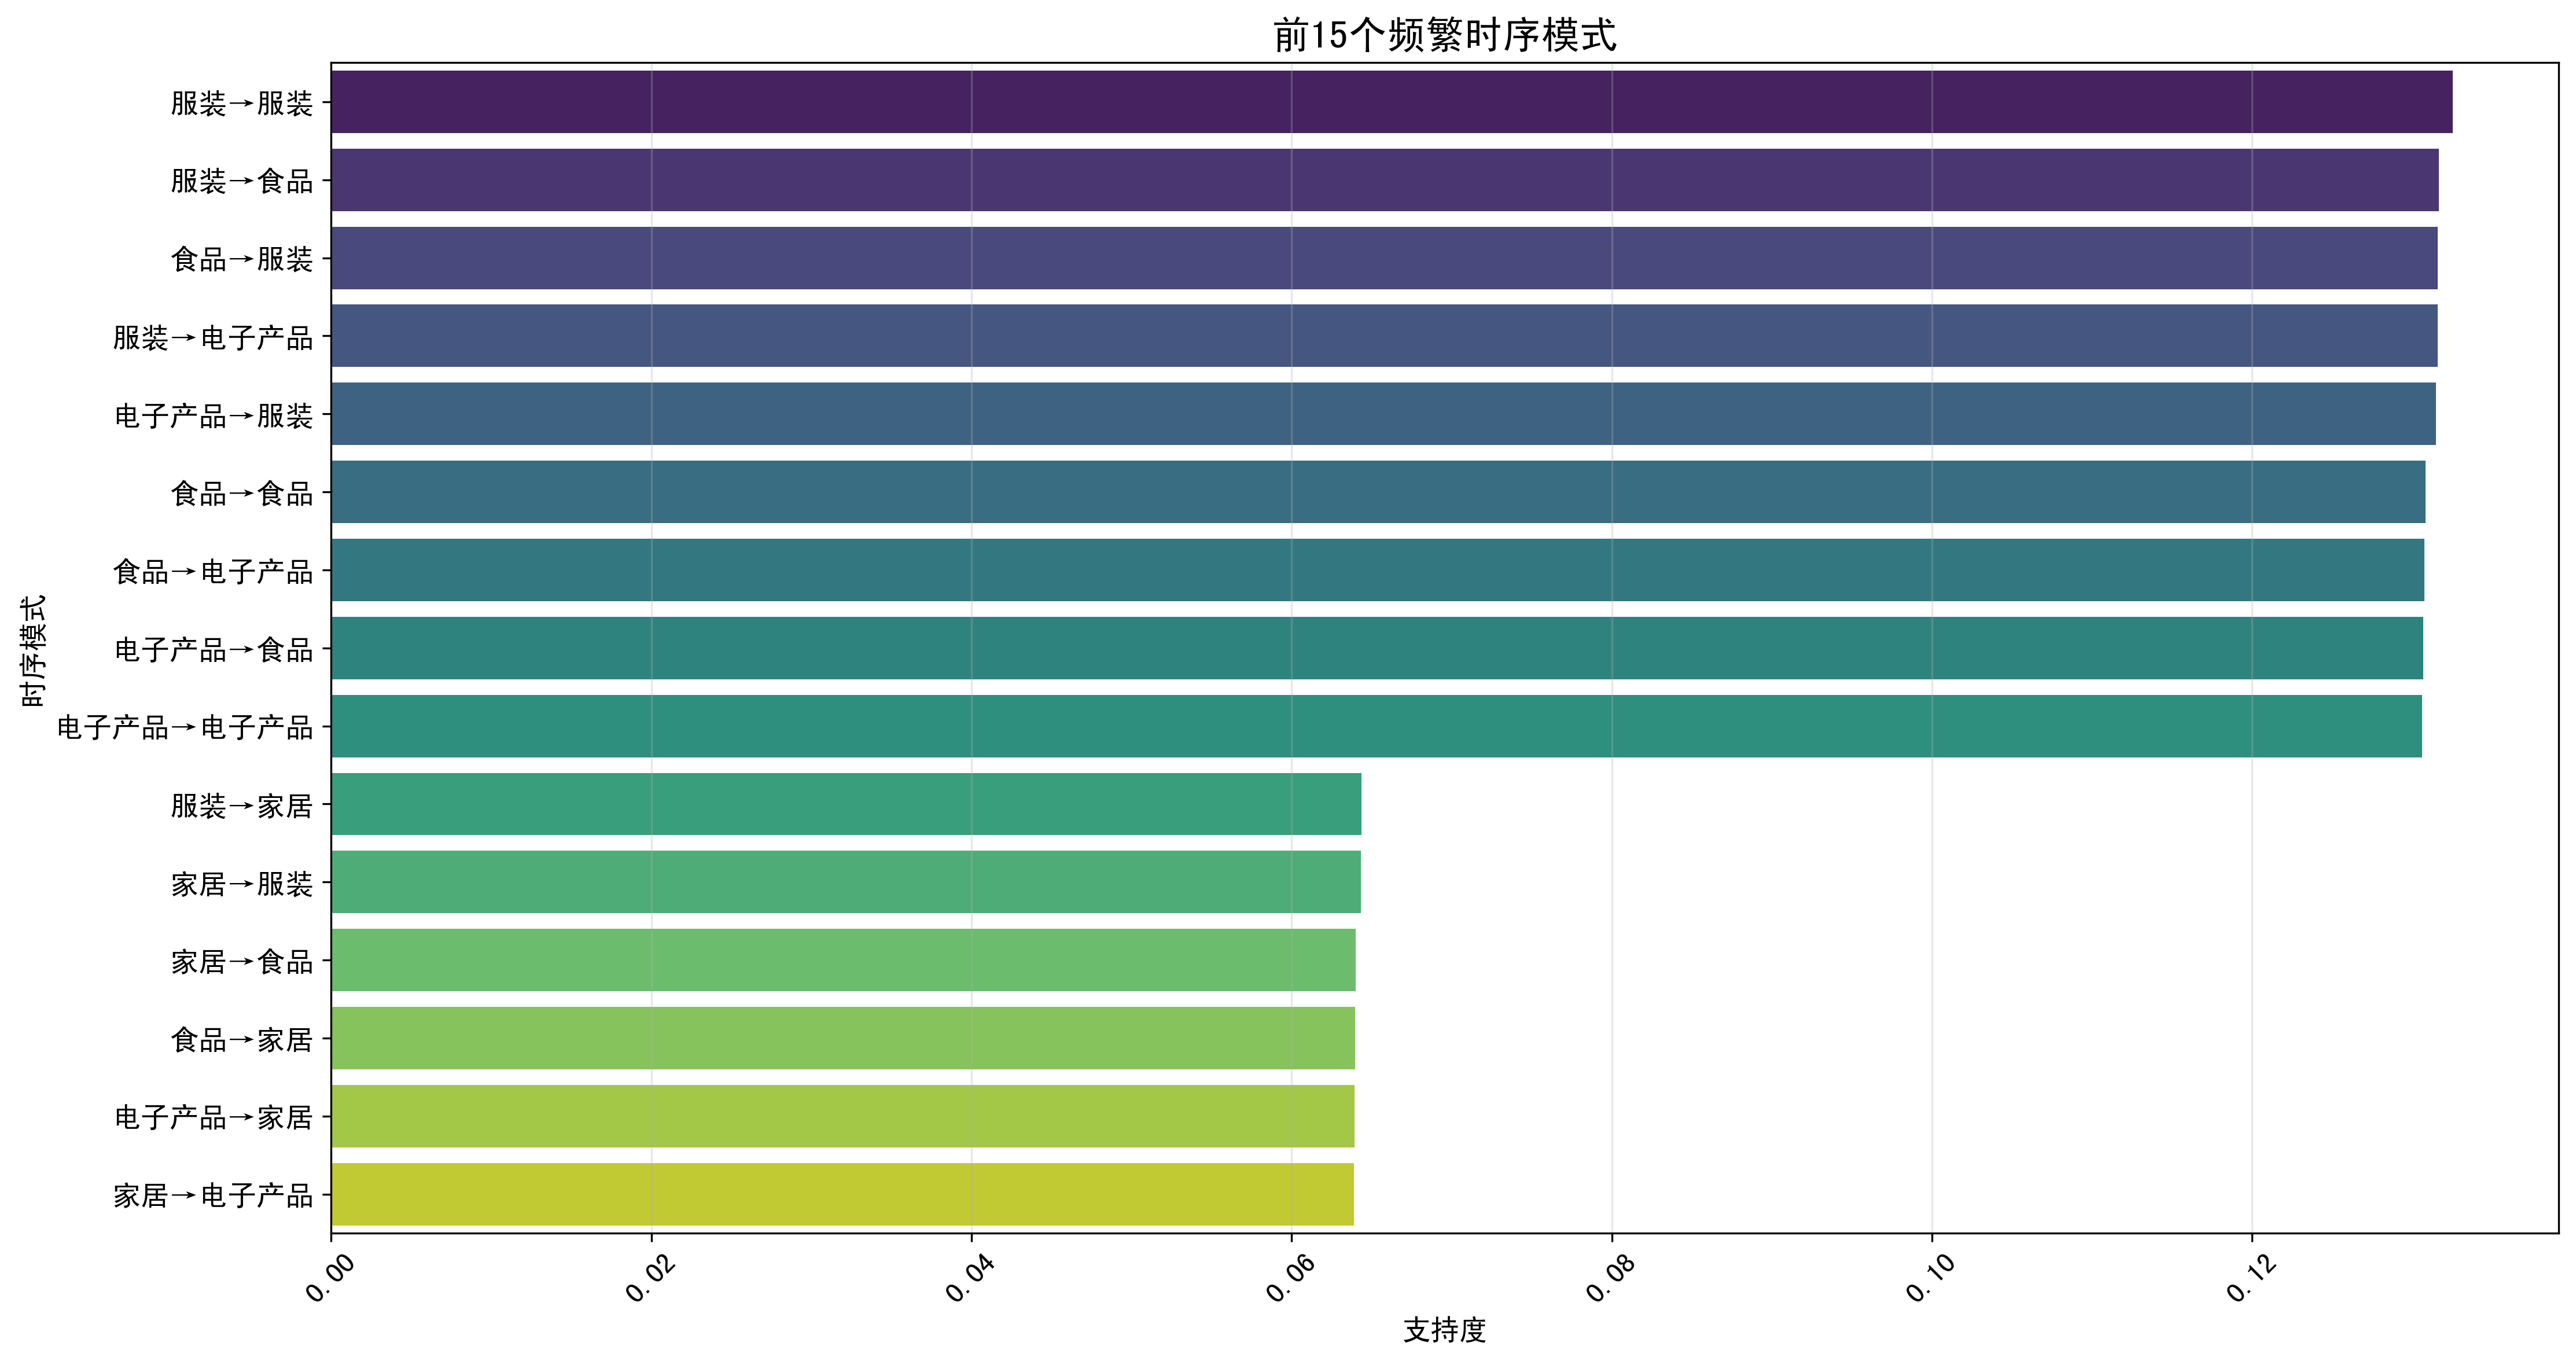

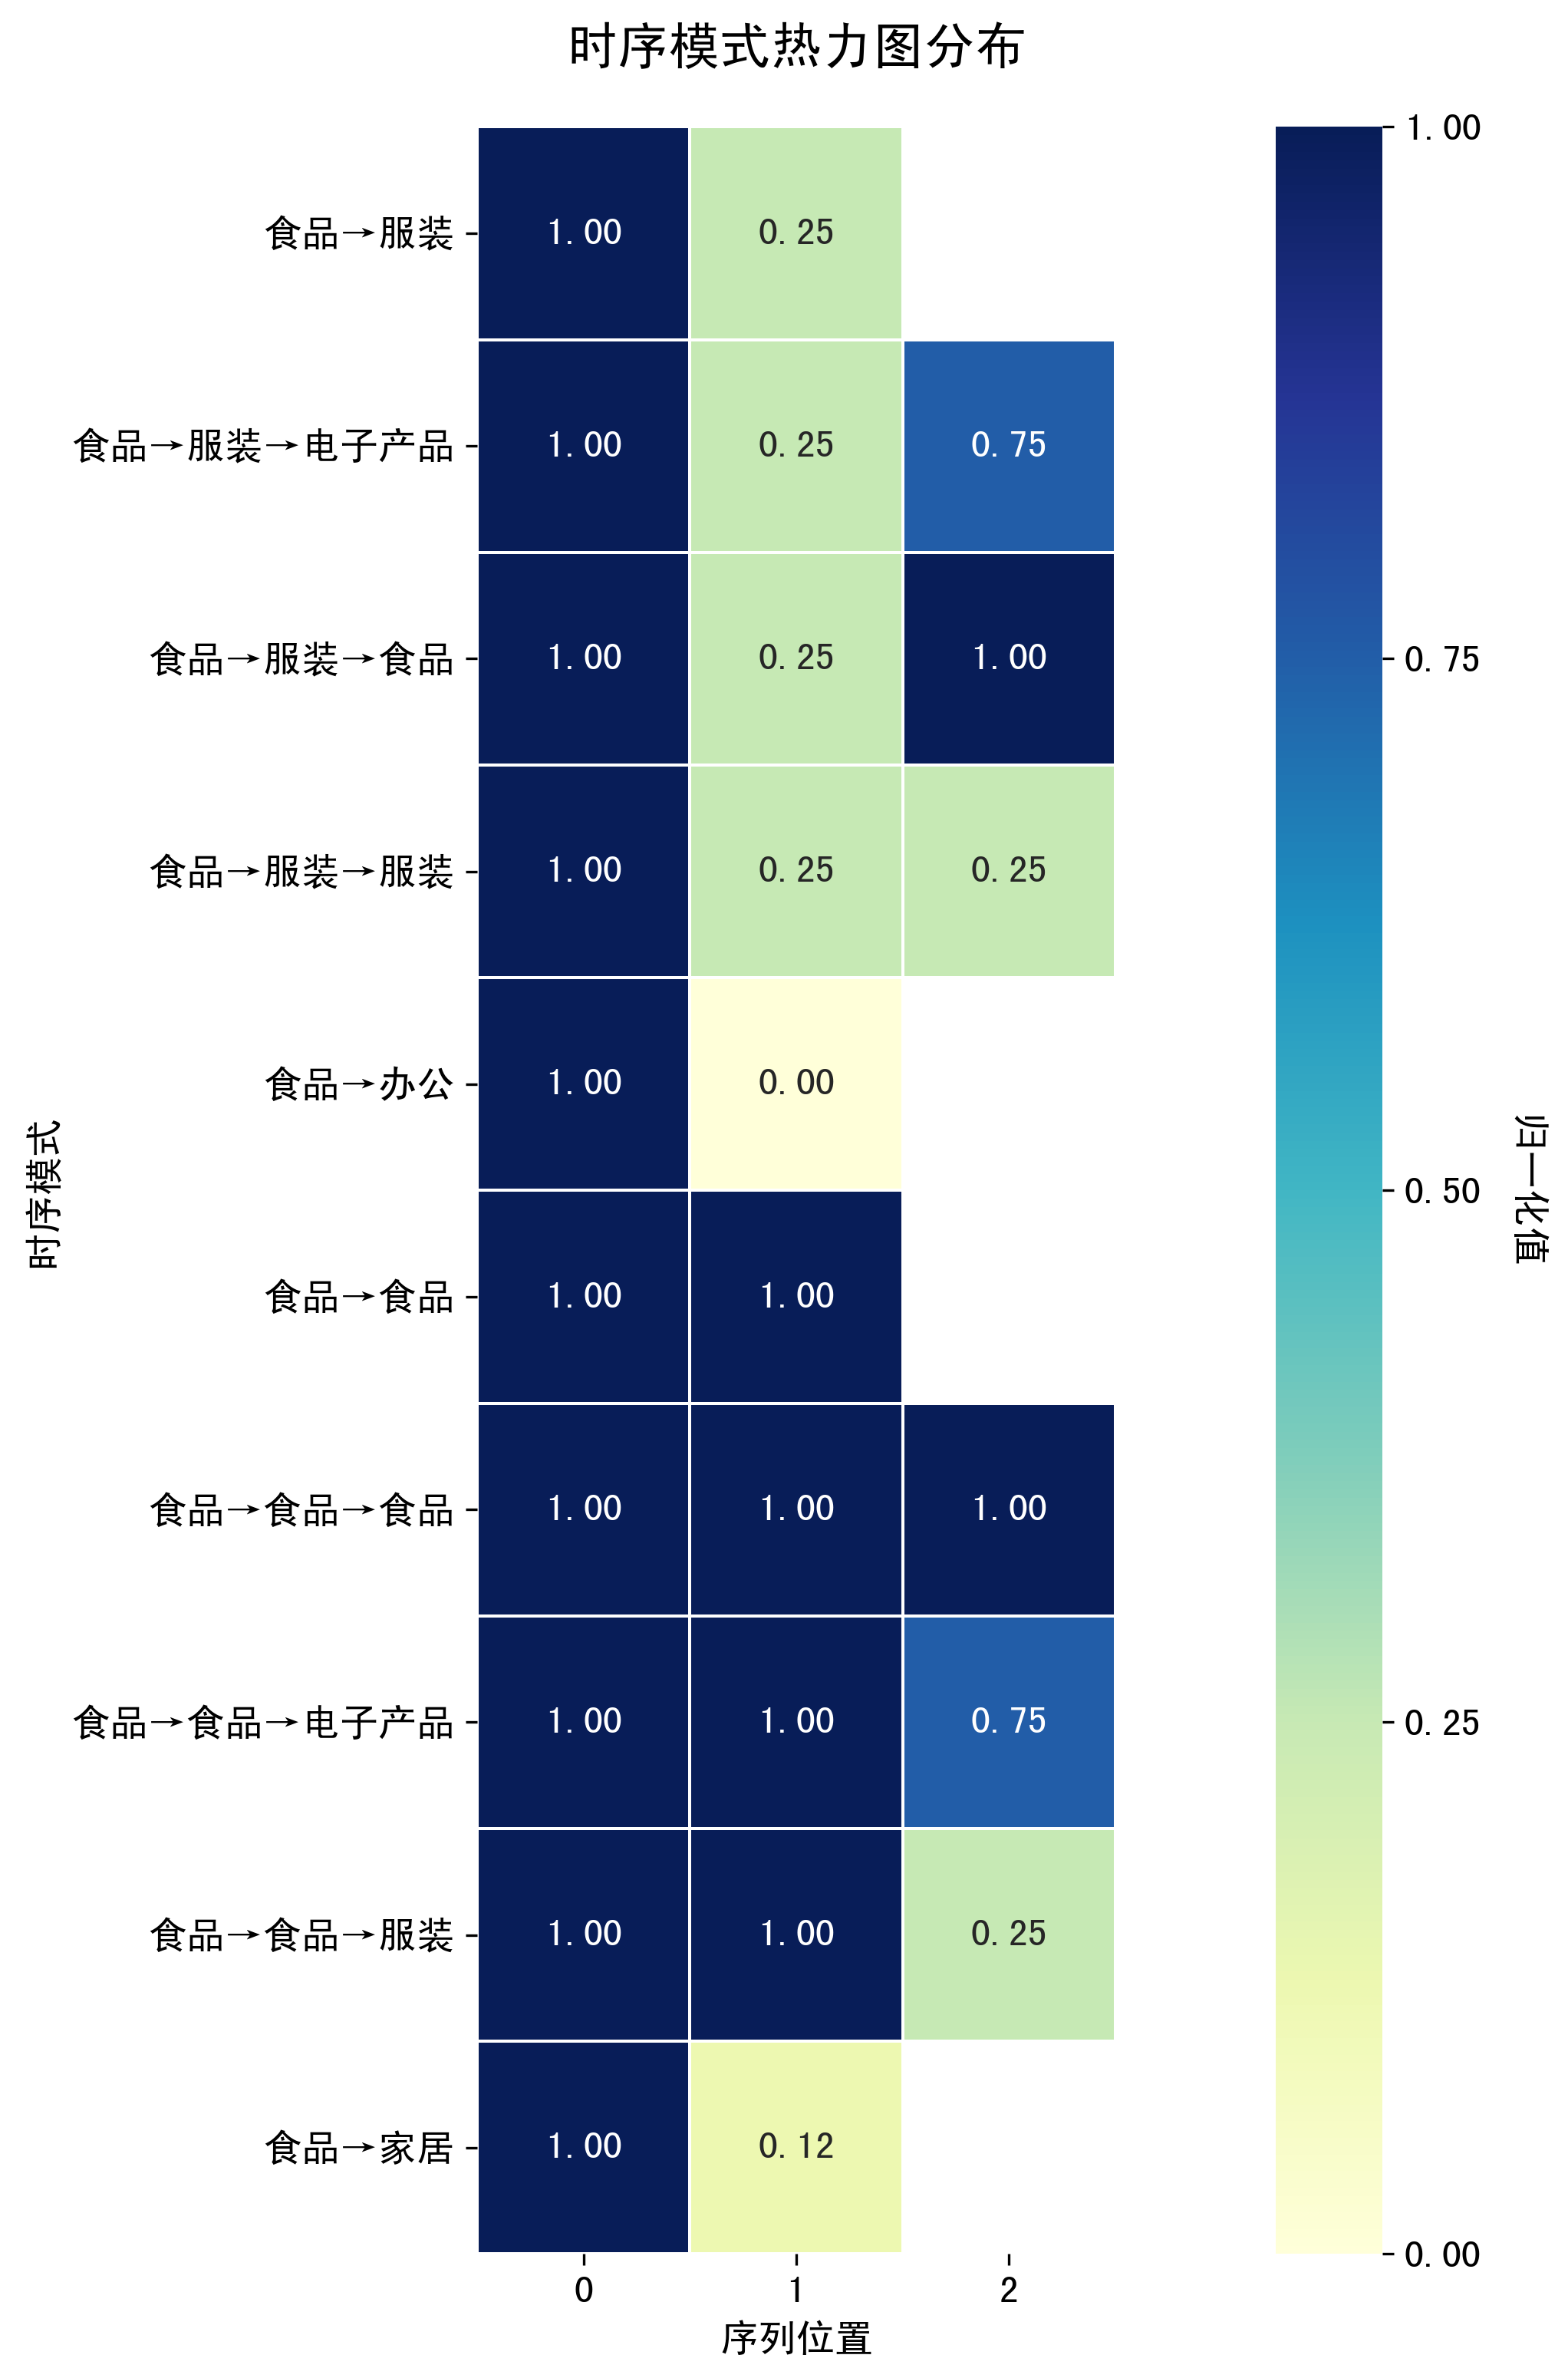

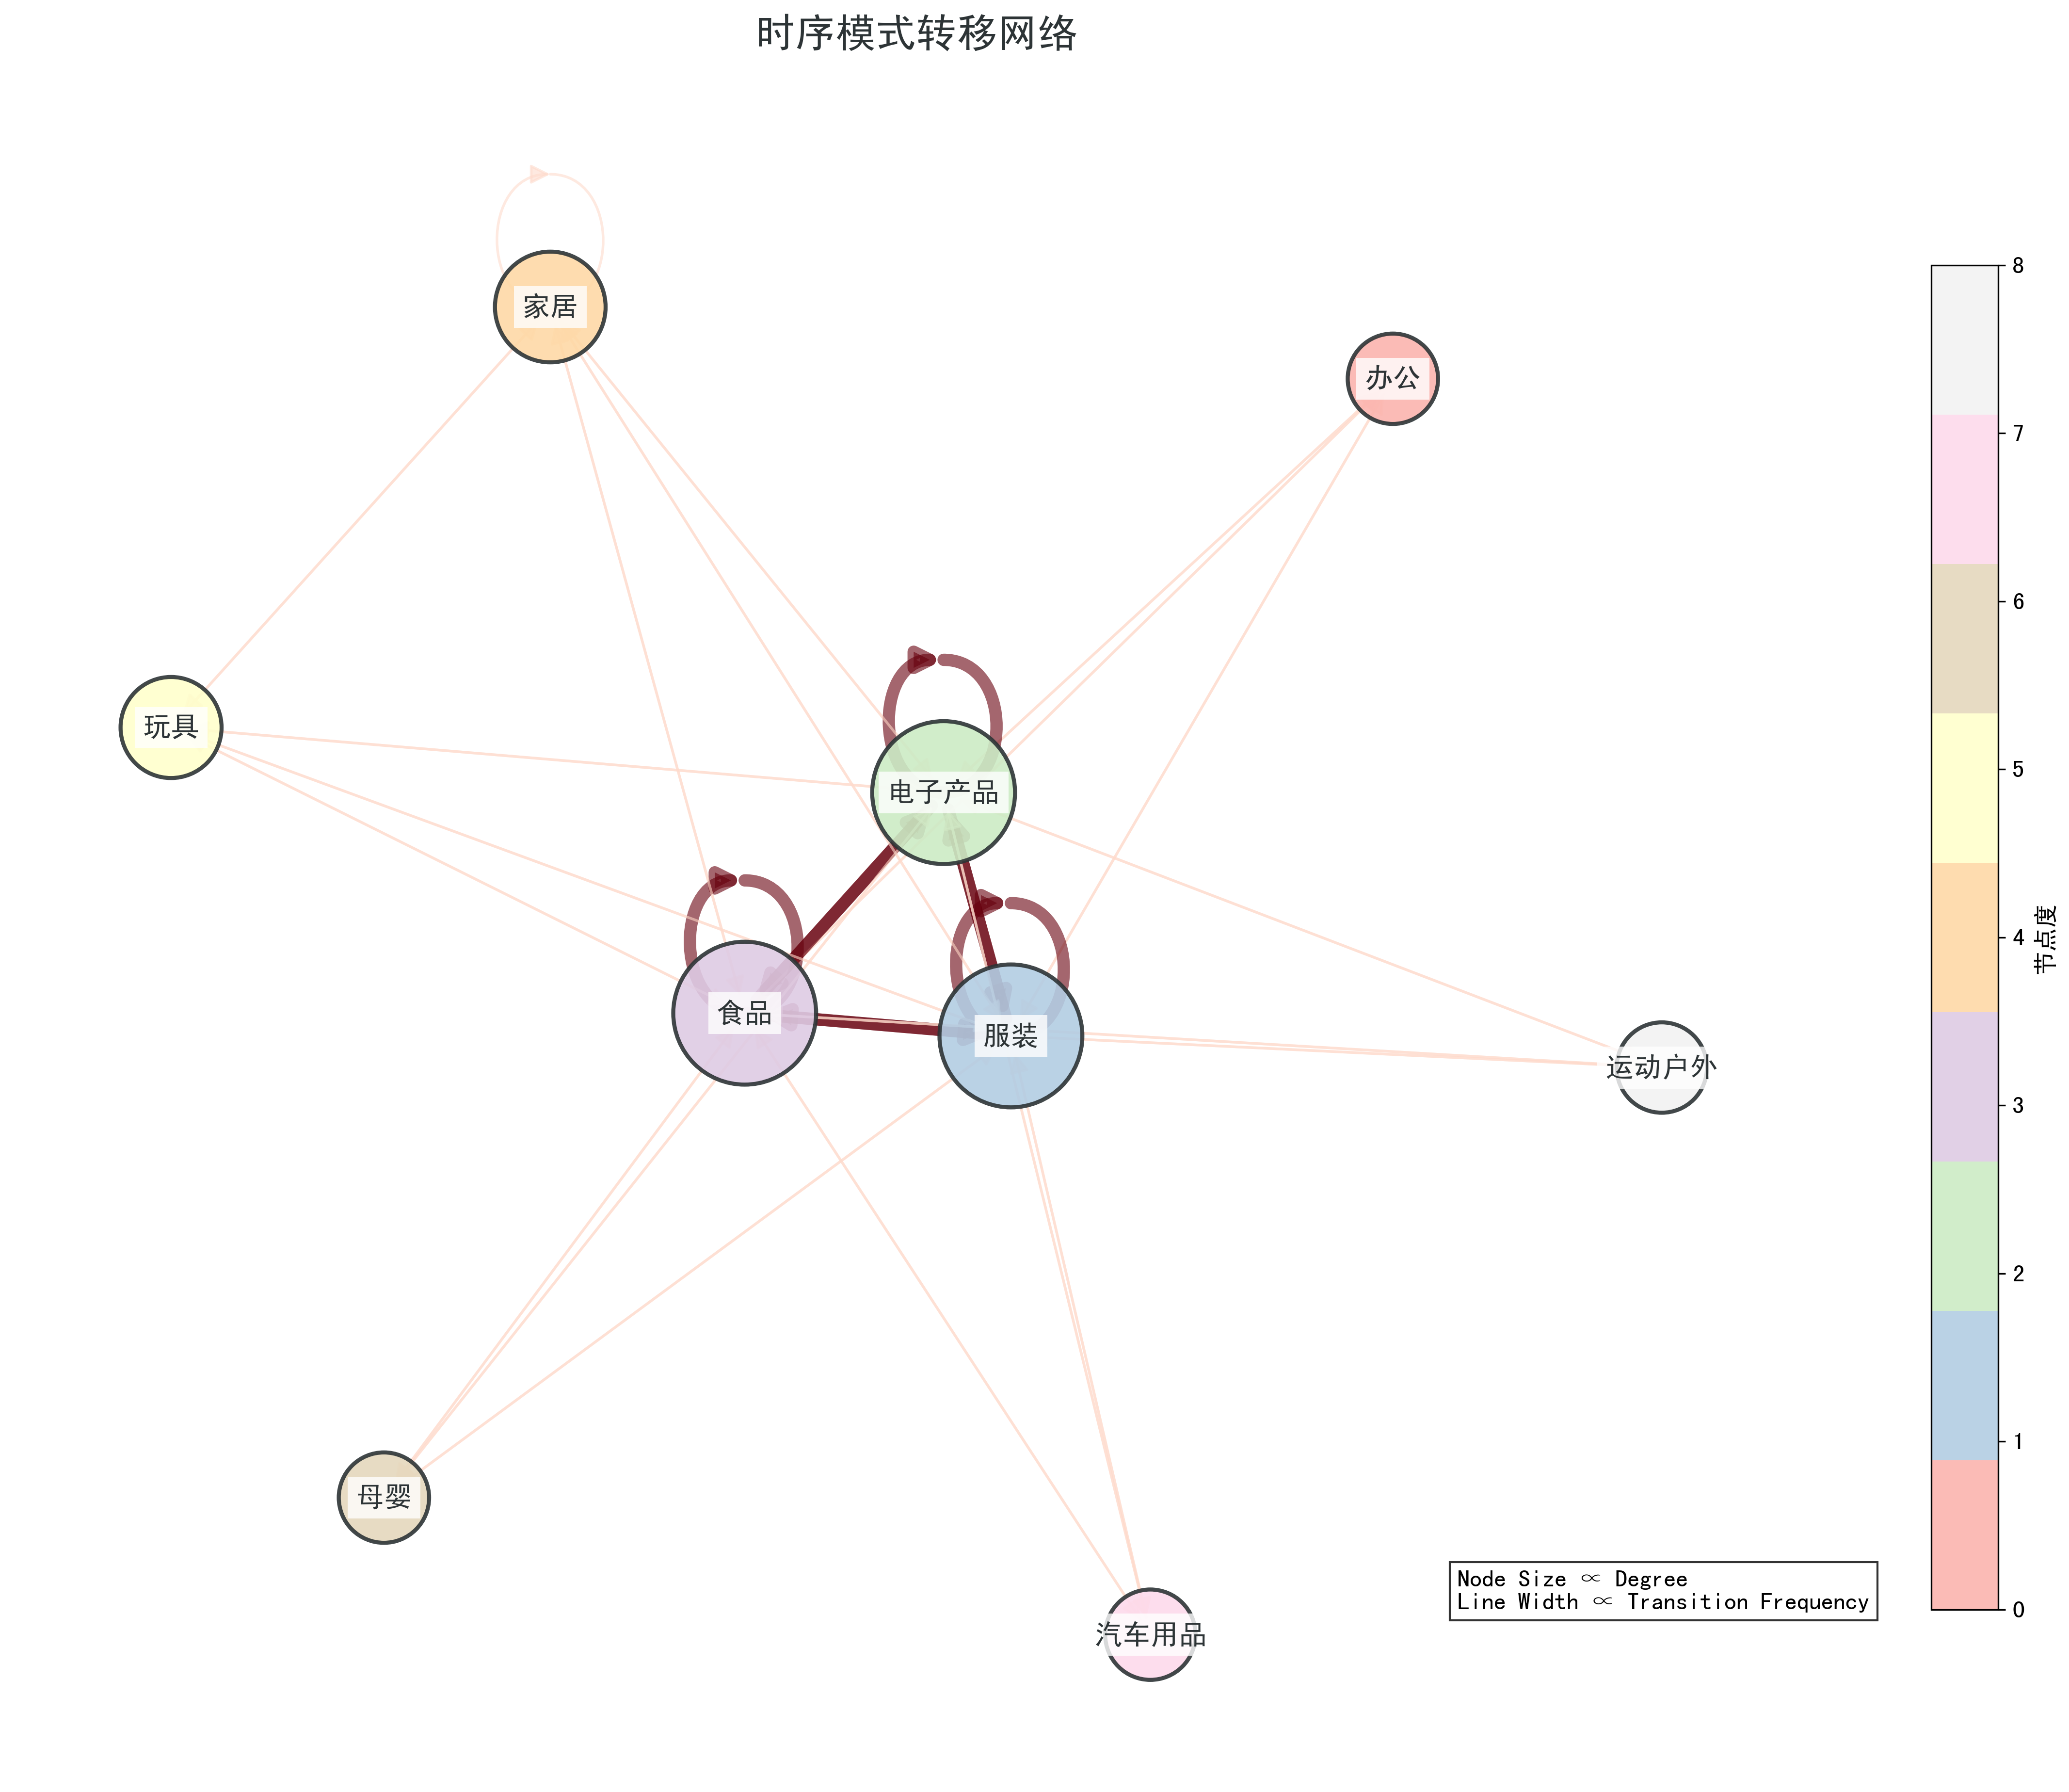

In [99]:
visulize_span_pattern(frequent_patterns)

In [100]:
# 可视化季节性购买模式
import calendar

def visualize_seasonal_patterns(df, filename_prefix):
    """
    可视化季节性购买模式 - 改进增强版
    """
    print("可视化季节性购买模式...")
    df['year'] = df['purchase_date'].dt.year
    df['month'] = df['purchase_date'].dt.month
    df['quarter'] = df['purchase_date'].dt.quarter
    df['day_of_week'] = df['purchase_date'].dt.dayofweek

    # categories 字段需要展开
    df = df.explode('categories')

    # 1. 按季度分析主要类别的购买频率
    quarterly_data = df.groupby(['quarter', 'categories']).size().unstack().fillna(0)
    quarterly_sums = quarterly_data.sum(axis=1)

    plt.figure(figsize=(10, 8))
    ax = quarterly_data.plot(kind='bar', stacked=True, ax=plt.gca(), color=custom_colors)

    # 添加百分比标签
    for container in ax.containers:
        labels = [
            f'{(val / quarterly_sums.iloc[i])*100:.1f}%' 
            for i, val in enumerate(container.datavalues)
        ]
        ax.bar_label(
            container, 
            labels=labels,
            label_type='center', 
            fontsize=14, 
            color='white', 
            fontweight='bold'
        )
        
    # 设置刻度标签大小
    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.title('各季度不同商品类别购买频率', fontsize=16, fontweight='bold')
    plt.xlabel('季度', fontsize=14)
    plt.ylabel('购买频率', fontsize=14)
    plt.tick_params(axis='x', labelrotation=0)
    plt.tick_params(axis='y', labelrotation=0)
    plt.legend(title='商品类别', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{filename_prefix}_quarterly.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 2. 按月份分析 - 加强版可视化
    monthly_data = df.groupby(['month', 'categories']).size().unstack().fillna(0)
    
    # 2.1 堆叠条形图
    plt.figure(figsize=(16, 8))
    ax = monthly_data.plot(kind='bar', stacked=True, ax=plt.gca(), color=custom_colors)
    # 设置刻度标签大小
    ax.tick_params(axis='both', which='major', labelsize=12)
    # 添加总数标签
    # for i, total in enumerate(monthly_data.sum(axis=1)):
    #     plt.text(i, total + total*0.02, f'{int(total)}', ha='center', fontweight='bold', fontsize=14)
    
    plt.title('各月份不同商品类别购买频率', fontsize=16, fontweight='bold')
    plt.xlabel('月份', fontsize=14)
    plt.ylabel('购买频率', fontsize=14)
    plt.tick_params(axis='x', labelrotation=0)
    plt.tick_params(axis='y', labelrotation=0)
    plt.legend(title='商品类别', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{filename_prefix}_monthly_stacked.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 2.2 折线图展示月度趋势
    plt.figure(figsize=(16, 10))
    
    # 转换为百分比
    monthly_pct = monthly_data.div(monthly_data.sum(axis=1), axis=0) * 100
    
    # 绘制折线图
    for i, category in enumerate(monthly_pct.columns):
        plt.plot(monthly_pct.index, monthly_pct[category], marker='o', linewidth=2, 
                label=category, color=custom_colors[i % len(custom_colors)])
        
    plt.title('各月份商品类别购买占比趋势', fontsize=16, fontweight='bold')
    plt.xlabel('月份', fontsize=14)
    plt.ylabel('购买占比(%)', fontsize=14)
    plt.tick_params(axis='x', labelrotation=0)
    plt.tick_params(axis='y', labelrotation=0)
    plt.grid(True, alpha=0.3)
    plt.legend(title='商品类别', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(monthly_pct.index)
    plt.tight_layout()
    plt.savefig(f'{filename_prefix}_monthly_trend.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 3. 按星期分析 - 分组柱状图展示
    weekly_data = df.groupby(['day_of_week', 'categories']).size().unstack().fillna(0)
    day_names = [calendar.day_name[i][:3] for i in range(7)]
    weekly_data.index = day_names
    
    # 3.1 分组柱状图
    plt.figure(figsize=(18, 8))
    ax = weekly_data.plot(kind='bar', ax=plt.gca(), color=custom_colors, width=0.75)
    
    # 添加数据标签
    # for container in ax.containers:
    #     ax.bar_label(container, label_type='center', fmt='%.0f', fontsize=12, color='white', fontweight='bold')
    
    plt.title('各周几不同商品类别购买频率', fontsize=16, fontweight='bold')
    plt.xlabel('星期', fontsize=14)
    plt.ylabel('购买频率', fontsize=14)
    plt.tick_params(axis='x', labelrotation=0)
    plt.tick_params(axis='y', labelrotation=0)
    plt.legend(title='商品类别', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{filename_prefix}_weekly_bar.png', dpi=300, bbox_inches='tight')
    plt.close()

    # 新增时间段划分（核心代码）
    time_bins = [0, 5, 9, 12, 14, 18, 24]
    time_labels = ['凌晨(0-6)', '早晨(6-8)', '上午(8-12)', 
                  '中午(12-14)', '下午(14-18)', '晚上(18-24)']
    
    df['time_period'] = pd.cut(
        df['purchase_date'].dt.hour,
        bins=time_bins,
        labels=time_labels,
        right=False,  # 左闭右开区间
        ordered=True
    )
    
    # 4. 时间段分析 - 新增模块
    period_data = df.groupby(['time_period', 'categories']).size().unstack().fillna(0)
    
    # 4.1 堆叠条形图（带百分比标签）
    plt.figure(figsize=(16, 8))
    ax = period_data.plot(kind='bar', stacked=True, color=custom_colors)
    # period_sums = period_data.sum(axis=1)
    
    # 添加动态百分比标签
    # for container in ax.containers:
    #     labels = [
    #         f'{(val/period_sums.iloc[i])*100:.1f}%' 
    #         if val > 0 else '' 
    #         for i, val in enumerate(container.datavalues)
    #     ]
    #     ax.bar_label(
    #         container, 
    #         labels=labels,
    #         label_type='center',
    #         fontsize=12,
    #         color='white',
    #         fontweight='bold'
    #     )
    
    plt.title('各时间段商品类别购买分布', fontsize=16)
    plt.xlabel('时间段', fontsize=14)
    plt.ylabel('购买量', fontsize=14)
    plt.legend(title='商品类别', bbox_to_anchor=(1.05, 1))
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{filename_prefix}_time_periods.png', dpi=300, bbox_inches='tight')
    plt.close()

    # 旬段分析
    df['period_in_month'] = df['purchase_date'].apply(
        lambda x: '上旬' if x.day <= 10 else '中旬' if x.day <= 20 else '下旬')
    period_data = df.groupby(['period_in_month', 'categories']).size().unstack().fillna(0)
    plt.figure(figsize=(12, 8))
    period_data.plot(kind='bar', stacked=True, color=custom_colors)
    plt.title('各旬段商品类别购买分布', fontsize=16)
    plt.xlabel('时间段', fontsize=14)
    plt.ylabel('购买量', fontsize=14)
    plt.legend(title='商品类别', bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.savefig(f'{filename_prefix}_month_period_segments.png', dpi=300)
    plt.close()


In [101]:
len(processed_df)

61776823

In [ ]:
# processed_df = processed_df[:1000000]

In [102]:
visualize_seasonal_patterns(processed_df, 'output/seasonal_patterns')

可视化季节性购买模式...


/tmp/ipykernel_422282/1435267695.py:136: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  period_data = df.groupby(['time_period', 'categories']).size().unstack().fillna(0)


<Figure size 4800x2400 with 0 Axes>

<Figure size 3600x2400 with 0 Axes>

In [103]:
# 分析时序模式
analyze_sequential_patterns(processed_df, 'output/sequential_patterns')

分析时序模式...


/tmp/ipykernel_422282/2097682935.py:133: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9926863206608812' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  strength_matrix.loc[source, target] = count / max_count
/tmp/ipykernel_422282/2097682935.py:133: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9922172973213614' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  strength_matrix.loc[source, target] = count / max_count
/tmp/ipykernel_422282/2097682935.py:133: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9917500266849041' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  strength_matrix.loc[source, target] = count / max_c